In [36]:
import sys
from trails.optimizer import trans_emiss_calc
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
import numpy as np
from trails.optimizer import forward_loglik, post_prob_wrapper, viterbi
import pandas as pd
import time
import re
import msprime
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [37]:
ILS = 30

In [38]:
####################### Model parameters #######################


t_A = 200000
t_B = 200000
t_C = 200000
t_1 = max([t_A, t_B, t_C])
t_2 = 80000
N_AB = -t_2/np.log(3/2*ILS/100)
N_ABC = 60000
t_3 = t_1*5
r = 0.5e-8
mu = 2e-8
n_int_AB = 5
n_int_ABC = 7

t_out = t_1+t_2+t_3+2*N_ABC

N_ref = N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC, coal_ABC)[-2]*N_ref
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_AB, coal_AB)*N_ref
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, coal_ABC)*N_ref

(2/3)*(np.exp(-t_2/(N_AB)))

0.3

In [39]:
N_AB

100186.88658722976

In [41]:
cut_AB

array([200000.        , 211675.16023281, 224892.57002535, 240122.6005454 ,
       258090.20982508, 280000.        ])

In [40]:
cut_ABC

array([280000.        , 289249.04078964, 300188.33419727, 313576.94727613,
       330837.87162323, 355165.77810972, 396754.60894332,             inf])

In [32]:
transitions, emissions, starting, hidden_states, observed_states = trans_emiss_calc(
    t_A*mu, t_B*mu, t_C*mu, t_2*mu, t_upper*mu, t_out*mu, 
    N_AB*mu, N_ABC*mu, r/mu, n_int_AB, n_int_ABC,
    cut_AB = 'standard', cut_ABC = 'standard'
)

In [42]:
dct_hid = {v: k for k, v in hidden_states.items()}
dct = {v: k for k, v in observed_states.items()}

In [58]:
####################### Add demography #######################

n_sites = 100_000
seed = 10

demography = msprime.Demography()
demography.add_population(name="A", initial_size=N_AB, default_sampling_time=t_1-t_A)
demography.add_population(name="B", initial_size=N_AB, default_sampling_time=t_1-t_B)
demography.add_population(name="C", initial_size=N_AB, default_sampling_time=t_1-t_C)
demography.add_population(name="D", initial_size=N_AB, default_sampling_time=t_1-t_1)
demography.add_population(name="AB", initial_size=N_AB)
demography.add_population(name="ABC", initial_size=N_ABC)
demography.add_population(name="ABCD", initial_size=N_ABC)
demography.add_population_split(time=t_1, derived=["A", "B"], ancestral="AB")
demography.add_population_split(time=t_1+t_2, derived=["AB", "C"], ancestral="ABC")
demography.add_population_split(time=t_1+t_2+t_3, derived=["ABC", "D"], ancestral="ABCD")

ts = msprime.sim_ancestry(
    {"A": 1, "B": 1, "C": 1,
     "D": 1
    },
    demography=demography,
    recombination_rate=r,
    sequence_length=n_sites,
    ploidy=1,
    random_seed=seed
)


In [59]:
#### Add mutations

mutated_ts = msprime.sim_mutations(ts, rate=mu, random_seed=seed)

nochange_lst = [dct['AAAA'], dct['CCCC'], dct['TTTT'], dct['GGGG']]
np.random.seed(seed) ; sim_genome = np.random.choice(nochange_lst, n_sites)

mut_lst = []
mut_loc = []
for variant in mutated_ts.variants():
    mut_loc.append(variant.site.position)
    mut_lst.append(''.join([variant.alleles[i] for i in variant.genotypes]))

for i in range(len(mut_loc)):
    sim_genome[int(mut_loc[i])] = dct[mut_lst[i]]


In [60]:
# loglik = forward_loglik(transitions, emissions, starting, sim_genome)

In [61]:
post = post_prob_wrapper(transitions, emissions, starting, [sim_genome])[0]

In [62]:
# vit = viterbi(transitions, emissions, starting, sim_genome)

In [63]:
hidden_matrix = np.random.randint(max([n_int_AB, n_int_ABC]), size=(len(dct_hid), 4))
hidden_matrix[:,0] = list(range(len(dct_hid)))
hidden_matrix[:,1] = [i[0] for i in dct_hid.keys()]
hidden_matrix[:,2] = [i[1] for i in dct_hid.keys()]
hidden_matrix[:,3] = [i[2] for i in dct_hid.keys()]

In [64]:
left_lst = []
right_lst = []
tree_state = []
t_AB_vec = []
t_ABC_vec = []
for t in ts.trees():
    # Append start coordinate
    left_lst.append(t.interval.left)
    # Append end coordinate
    right_lst.append(t.interval.right-1)
    # Get all non-zero coalescent times
    ntimes = [ts.nodes()[n].time for n in t.nodes() if ts.nodes()[n].time not in [0, t_1-t_A, t_1-t_B, t_1-t_C]]
    ntimes = sorted(ntimes)
    # Get time of the first event
    mint = ntimes[0]
    mint2 = ntimes[1]
    # Find topology
    find_re = re.findall("n\d,n\d", t.as_newick(include_branch_lengths=False))[0]
    # Sort species within topology
    find_re = sorted(find_re.split(','))
    # If V0 or V1
    if find_re == ['n0', 'n1']:
        # If the time of the first coalescent is larger than the deepest speciation event
        if mint>=(t_1+t_2):
            state = (1, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V1 state
        else:
            state = (0, (mint>cut_AB).sum()-1, (mint2>cut_ABC).sum()-1)
            # Append V0 state
    # If V2
    elif find_re == ['n0', 'n2']:
        state = (2, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    # If V3
    elif find_re == ['n1', 'n2']:
        state = (3, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    else:
        state = (4, (mint>cut_ABC).sum()-1, (mint2>cut_ABC).sum()-1)
    tree_state.append(state)
    t_AB_vec.append(mint)
    t_ABC_vec.append(mint2)


In [65]:
tree_matrix = np.random.randint(max(left_lst), size=(len(left_lst), 3))
tree_matrix[:,0] = left_lst
tree_matrix[:,1] = right_lst
tree_matrix[:,2] = [dct_hid[i] for i in tree_state]

In [66]:
%%R -i post -i hidden_matrix -i tree_matrix

library(tidyverse)

hid_tab <- as_tibble(hidden_matrix) %>%
    rename(name = V1, topology = V2, int_1 = V3, int_2 = V4)
    
write_csv(hid_tab, 'hid_tab.csv')
    
tree_tab <- as_tibble(tree_matrix) %>%
    rename(start = V1, end = V2, name = V3) %>%
    mutate(
        gr = ifelse(lag(name) != name, 1, 0) %>% coalesce(0),
        gr = cumsum(gr) + 1
    ) %>% 
    group_by(gr, name) %>%
    summarize(start = min(start), end = max(end)) %>%
    left_join(hid_tab, by = 'name')
    
write_csv(tree_tab, 'tree_tab.csv')

post_tab <- as_tibble(post) %>%
    mutate(pos = 0:(n()-1)) %>%
    pivot_longer(-pos) %>%
    mutate(name = as.integer(str_remove_all(name, 'V'))-1) %>%
    left_join(hid_tab, by = 'name')
     
write_csv(post_tab, 'post_tab.csv')

`summarise()` has grouped output by 'gr'. You can override using the `.groups` argument.


In [42]:
%%R

library(tidyverse)

hid_tab <- read_csv('hid_tab.csv')
tree_tab <- read_csv('tree_tab.csv')
post_tab <- read_csv('post_tab.csv')

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Rows: 119 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): name, topology, int_1, int_2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 155 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): gr, name, start, end, topology, int_1, int_2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 11900000 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (6): pos, name, value, topology, int_1, int_2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [44]:
%%R -w 2000 -h 700 -r 150 -i n_int_AB -i n_int_ABC

p1 <- post_tab %>%
    mutate(is_V0 = topology == 0) %>%
    group_by(pos, is_V0, int_1) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_1+(!is_V0)*(n_int_AB), fill = prob, color = prob)) +
    geom_hline(aes(yintercept = n_int_AB-1+0.5), color = 'white') +
    geom_segment(aes(x = start, xend = end, y = int_1+(!(topology == 0))*(n_int_AB), yend = int_1+(!(topology == 0))*(n_int_AB)), 
                 color = 'green3', size = 2,
                 data = tree_tab) +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno"
                        ) +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno"
                         ) +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0:(n_int_AB-1), ((n_int_AB):(n_int_AB+n_int_ABC-1))+0.1), 
        labels = c(0:(n_int_AB-1), 0:(n_int_ABC-1)),
        expand = c(0, 0)
    ) +
    labs(y = 'First coalescent', x = 'Position')

`summarise()` has grouped output by 'pos', 'is_V0'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.


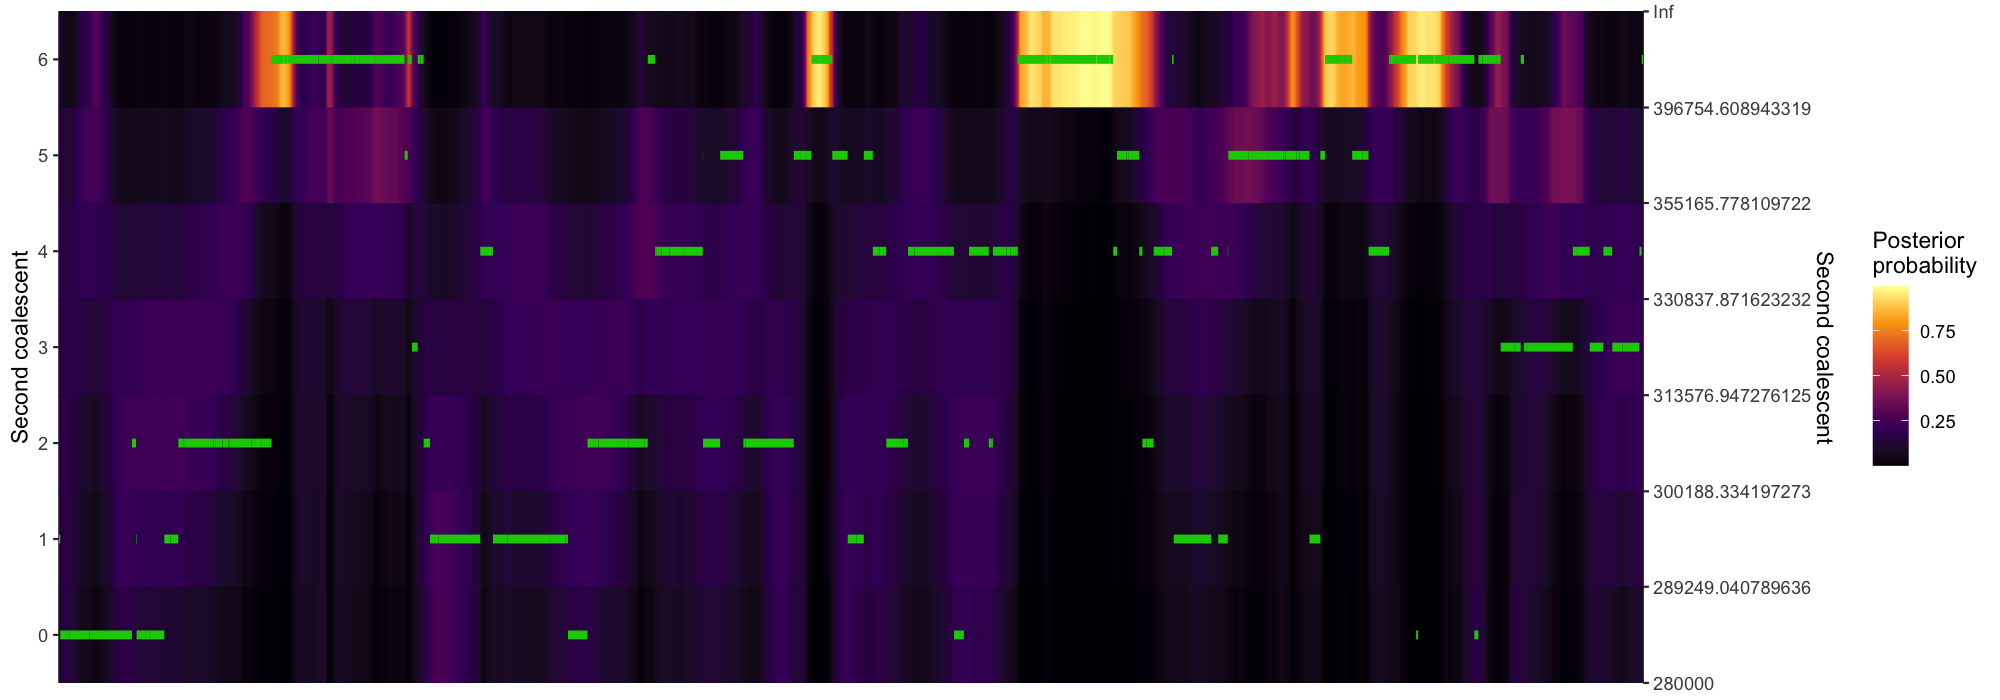

In [46]:
%%R -w 2000 -h 700 -r 150 -i cut_ABC

p2 <- post_tab %>%
    group_by(pos, int_2) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_2, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = int_2, yend = int_2), 
                 color = 'green3', size = 2,
                 data = tree_tab) +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = 0:(n_int_ABC-1), 
        labels = 0:(n_int_ABC-1),
        expand = c(0, 0)
    ) +
    labs(y = 'Second coalescent') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank()
    )

In [86]:
%%R -w 2000 -h 700 -r 150

p3 <- post_tab %>%
    group_by(pos, topology) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, topology, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = topology, yend = topology), 
                 color = 'green3', size = 2,
                 data = tree_tab) +
    scale_fill_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno") +
    scale_color_viridis_c(name = 'Posterior\nprobability', 
                         # limits = c(0, 1)
                         option="inferno") +
    scale_x_continuous(expand = c(0, 0)) +
    scale_y_continuous(
        breaks = c(0, 1, 2, 3), 
        labels = c('V0', 'V1', 'V2', 'V3'),
        expand = c(0, 0)
    ) +
    labs(y = 'Topology') +
    theme(
        axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x=element_blank()
    )

`summarise()` has grouped output by 'pos'. You can override using the `.groups` argument.


In [87]:
%%R -w 2000 -h 1000 -r 150 -i ILS

library(patchwork)

p3/p2/p1 + 
  plot_layout(heights = c(4, n_int_ABC, n_int_AB+n_int_ABC))

# ggsave(paste0('posterior_decoding_', round(ILS), '.pdf'), width = 14, height = 7)
ggsave(paste0('posterior_decoding_', n_int_AB, '_', n_int_ABC, '_', round(ILS), '.png'), width = 14, height = 9)

In [57]:
%%R

tree_tab %>%
    group_by(topology %in% c(0, 1)) %>%
    summarize(len = sum(end-start))

# A tibble: 2 × 2
  `topology %in% c(0, 1)`    len
  <lgl>                    <dbl>
1 FALSE                    64476
2 TRUE                    135201
